#  Going Deeper On Molecular Featurizations

One of the most important steps of doing machine learning on molecular data is transforming the data into a form amenable to the application of learning algorithms. This process is broadly called "featurization" and involves turning a molecule into a vector or tensor of some sort. There are a number of different ways of doing that, and the choice of featurization is often dependent on the problem at hand. We have already seen two such methods: molecular fingerprints, and `ConvMol` objects for use with graph convolutions. In this tutorial we will look at some of the others.

## Colab

This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Going_Deeper_on_Molecular_Featurizations.ipynb)



In [41]:
!pip install -qq --pre deepchem
import deepchem
import warnings
warnings.filterwarnings('ignore')
deepchem.__version__

'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


'2.6.0.dev'

## Featurizers

In DeepChem, a method of featurizing a molecule (or any other sort of input) is defined by a `Featurizer` object.  There are three different ways of using featurizers.

1. When using the MoleculeNet loader functions, you simply pass the name of the featurization method to use.  We have seen examples of this in earlier tutorials, such as `featurizer='ECFP'` or `featurizer='GraphConv'`.

2. You also can create a Featurizer and directly apply it to molecules.  For example:

In [42]:
import deepchem as dc

featurizer = dc.feat.CircularFingerprint()
print(featurizer(['CC', 'CCC', 'CCO']))

[21:56:25] DEPRECATION WARNING: please use MorganGenerator
[21:56:25] DEPRECATION WARNING: please use MorganGenerator
[21:56:25] DEPRECATION WARNING: please use MorganGenerator


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


3. When creating a new dataset with the DataLoader framework, you can specify a Featurizer to use for processing the data.  We will see this in a future tutorial.

We use propane (CH<sub>3</sub>CH<sub>2</sub>CH<sub>3</sub>, represented by the SMILES string `'CCC'`) as a running example throughout this tutorial. Many of the featurization methods use conformers of the molecules. A conformer can be generated using the `ConformerGenerator` class in `deepchem.utils.conformers`. 

### RDKitDescriptors

`RDKitDescriptors` featurizes a molecule by using RDKit to compute values for a list of descriptors. These are basic physical and chemical properties: molecular weight, polar surface area, numbers of hydrogen bond donors and acceptors, etc. This is most useful for predicting things that depend on these high level properties rather than on detailed molecular structure.

Intrinsic to the featurizer is a set of allowed descriptors, which can be accessed using `RDKitDescriptors.allowedDescriptors`. The featurizer uses the descriptors in `rdkit.Chem.Descriptors.descList`, checks if they are in the list of allowed descriptors, and computes the descriptor value for the molecule.

Let's print the values of the first ten descriptors for propane.

In [43]:
from rdkit.Chem.Descriptors import descList
rdkit_featurizer = dc.feat.RDKitDescriptors()
features = rdkit_featurizer(['CCC'])[0]
descriptors = [i[0] for i in descList]
for feature, descriptor in zip(features[:10], descriptors):
    print(descriptor, feature)

MaxAbsEStateIndex 2.125
MaxEStateIndex 2.125
MinAbsEStateIndex 1.25
MinEStateIndex 1.25
qed 0.3854706587740357
SPS 6.0
MolWt 44.097
HeavyAtomMolWt 36.033
ExactMolWt 44.062600255999996
NumValenceElectrons 20.0


Of course, there are many more descriptors than this.

In [44]:
print('The number of descriptors present is: ', len(features))

The number of descriptors present is:  217


### WeaveFeaturizer and MolGraphConvFeaturizer

We previously looked at graph convolutions, which use `ConvMolFeaturizer` to convert molecules into `ConvMol` objects.  Graph convolutions are a special case of a large class of architectures that represent molecules as graphs.  They work in similar ways but vary in the details.  For example, they may associate data vectors with the atoms, the bonds connecting them, or both.  They may use a variety of techniques to calculate new data vectors from those in the previous layer, and a variety of techniques to compute molecule level properties at the end.

DeepChem supports lots of different graph based models.  Some of them require molecules to be featurized in slightly different ways.  Because of this, there are two other featurizers called `WeaveFeaturizer` and `MolGraphConvFeaturizer`.  They each convert molecules into a different type of Python object that is used by particular models.  When using any graph based model, just check the documentation to see what featurizer you need to use with it.

### CoulombMatrix

All the models we have looked at so far consider only the intrinsic properties of a molecule: the list of atoms that compose it and the bonds connecting them.  When working with flexible molecules, you may also want to consider the different conformations the molecule can take on.  For example, when a drug molecule binds to a protein, the strength of the binding depends on specific interactions between pairs of atoms.  To predict binding strength, you probably want to consider a variety of possible conformations and use a model that takes them into account when making predictions.

The Coulomb matrix is one popular featurization for molecular conformations.  Recall that the electrostatic Coulomb interaction between two charges is proportional to $q_1 q_2/r$ where $q_1$ and $q_2$ are the charges and $r$ is the distance between them.  For a molecule with $N$ atoms, the Coulomb matrix is a $N \times N$ matrix where each element gives the strength of the electrostatic interaction between two atoms.  It contains information both about the charges on the atoms and the distances between them.  More information on the functional forms used can be found [here](https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.108.058301).

To apply this featurizer, we first need a set of conformations for the molecule.  We can use the `ConformerGenerator` class to do this.  It takes a RDKit molecule, generates a set of energy minimized conformers, and prunes the set to only include ones that are significantly different from each other.  Let's try running it for propane.

In [45]:
from rdkit import Chem

generator = dc.utils.ConformerGenerator(max_conformers=5)
propane_mol = generator.generate_conformers(Chem.MolFromSmiles('CCC'))
print("Number of available conformers for propane: ", len(propane_mol.GetConformers()))

Number of available conformers for propane:  1


It only found a single conformer.  This shouldn't be surprising, since propane is a very small molecule with hardly any flexibility.  Let's try adding another carbon.

In [46]:
butane_mol = generator.generate_conformers(Chem.MolFromSmiles('CCCC'))
print("Number of available conformers for butane: ", len(butane_mol.GetConformers()))

Number of available conformers for butane:  3


Now we can create a Coulomb matrix for our molecule.

In [47]:
coulomb_mat = dc.feat.CoulombMatrix(max_atoms=20)
features = coulomb_mat(propane_mol)
print(features)

[[[36.8581052  12.48684436  7.56196875  2.85804542  2.85945164
    2.85804541  1.46740143  1.46740146  0.91279488  1.14239695
    1.14239686  0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]
  [12.48684436 36.8581052  12.48684457  1.45850729  1.46551208
    1.45850733  2.856895    2.85689499  1.46551214  1.45850729
    1.45850735  0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]
  [ 7.56196875 12.48684457 36.8581052   1.14239716  0.91279487
    1.14239667  1.46740155  1.46740152  2.8594516   2.85804528
    2.85804531  0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]
  [ 2.85804542  1.45850729  1.14239716  0.5         0.29325368
    0.29200274  0.17113412  0.21092508  0.13960187  0.16800025
    0.20540035  0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]
  [ 2.85945164  1.46

Notice that many elements are 0.  To combine multiple molecules in a batch we need all the Coulomb matrices to be the same size, even if the molecules have different numbers of atoms.  We specified `max_atoms=20`, so the returned matrix  has size (20, 20).  The molecule only has 11 atoms, so only an 11 by 11 submatrix is nonzero.

### CoulombMatrixEig

An important feature of Coulomb matrices is that they are invariant to molecular rotation and translation, since the interatomic distances and atomic numbers do not change.  Respecting symmetries like this makes learning easier.  Rotating a molecule does not change its physical properties.  If the featurization does change, then the model is forced to learn that rotations are not important, but if the featurization is invariant then the model gets this property automatically.

Coulomb matrices are not invariant under another important symmetry: permutations of the atoms' indices.  A molecule's physical properties do not depend on which atom we call "atom 1", but the Coulomb matrix does.  To deal with this, the `CoulumbMatrixEig` featurizer was introduced, which uses the eigenvalue spectrum of the Coulumb matrix and is invariant to random permutations of the atom's indices.  The disadvantage of this featurization is that it contains much less information ($N$ eigenvalues instead of an $N \times N$ matrix), so models will be more limited in what they can learn.

`CoulombMatrixEig` inherits from `CoulombMatrix` and featurizes a molecule by first computing the Coulomb matrices for different conformers of the molecule and then computing the eigenvalues for each Coulomb matrix. These eigenvalues are then padded to account for variation in number of atoms across molecules.

In [48]:
coulomb_mat_eig = dc.feat.CoulombMatrixEig(max_atoms=20)
features = coulomb_mat_eig(propane_mol)
print(features)

[[60.07620356 29.62963145 22.75497727  0.57137861  0.28781334  0.28548339
   0.27558185  0.18163797  0.17460999  0.17059716  0.16640101  0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]]


### SMILES Tokenization and Numericalization


So far, we have looked at featurization techniques that translate the implicit structural and physical information in SMILES data into more explicit features that help our models learn and make predictions. In this section, we will preprocess SMILES strings into a format that can be fed to sequence models, such as 1D convolutional neural networks and transformers, and enables these models to learn their own representations of molecular properties.

To prepare SMILES strings for a sequence model, we break them down into lists of substrings (called tokens) and turn them into lists of integer values (numericalization). Sequence models use those integer values as indices of an embedding matrix, which contains a vector of floating-point numbers for each token in the vocabulary. These embedding vectors are updated during model training. This process allows the sequence model to learn its own representations of the molecular properties implicit in the training data.

We will use DeepChem's `BasicSmilesTokenizer` and the Tox21 dataset from MoleculeNet to demonstrate the process of tokenizing SMILES.

In [49]:
import numpy as np

In [50]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer="Raw")
train_dataset, valid_dataset, test_dataset = datasets
print(train_dataset)

[21:57:01] WARNING: not removing hydrogen atom without neighbors
[21:57:07] Explicit valence for atom # 8 Al, 6, is greater than permitted
Failed to featurize datapoint 1322, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[21:57:11] Explicit valence for atom # 3 Al, 6, is greater than permitted
Failed to featurize datapoint 2290, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[21:57:11] Explicit valence for ato

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7831,) + inhomogeneous part.

We loaded the datasets with `featurizer="Raw"`. Now we obtain the SMILES from their `ids` attributes.

In [ ]:
train_smiles = train_dataset.ids
valid_smiles = valid_dataset.ids
test_smiles = test_dataset.ids
print(train_smiles[:5])

['CC(O)(P(=O)(O)O)P(=O)(O)O' 'CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C'
 'OC[C@H](O)[C@@H](O)[C@H](O)CO'
 'CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]' 'CC(C)COC(=O)C(C)C']


Next we define our tokenizer and `map` it onto all our data to convert the SMILES strings into lists of tokens. The `BasicSmilesTokenizer` breaks down SMILES roughly at atom level.

In [ ]:
tokenizer = dc.feat.smiles_tokenizer.BasicSmilesTokenizer()

train_tok = list(map(tokenizer.tokenize, train_smiles))
valid_tok = list(map(tokenizer.tokenize, valid_smiles))
test_tok = list(map(tokenizer.tokenize, test_smiles))
print(train_tok[0])
len(train_tok)

['C', 'C', '(', 'O', ')', '(', 'P', '(', '=', 'O', ')', '(', 'O', ')', 'O', ')', 'P', '(', '=', 'O', ')', '(', 'O', ')', 'O']


6264

Now we have tokenized versions of all SMILES strings in our dataset. To convert those into lists of integer values we first need to create a list of all possible tokens in our dataset. That list is called the vocabulary. We also add the empty string `""` to our vocabulary in order to correctly handle trailing zeros when decoding zero-padded numericalized SMILES.

In [ ]:
flatten = lambda l: [item for items in l for item in items]

all_toks = flatten(train_tok) + flatten(valid_tok) + flatten(test_tok)
vocab = sorted(set(all_toks + [""]))
print(vocab[:12], "...", vocab[-12:])
len(vocab)

['', '#', '(', ')', '-', '.', '/', '1', '2', '3', '4', '5'] ... ['[n+]', '[n-]', '[nH+]', '[nH]', '[o+]', '[s+]', '[se]', '\\', 'c', 'n', 'o', 's']


128

To numericalize tokenized SMILES strings we create a `str2int` dictionary which assigns a number to each token in the dictionary. We also create the reverse `int2str` dictionary and define the corresponding `encode` and `decode` functions. Finally we `map` the `encode` function on the tokenized data to obtain numericalized SMILES data.

In [ ]:
str2int = {s:i for i, s in enumerate(vocab)}
int2str = {i:s for i, s in enumerate(vocab)}
print(f"str2int: {dict(list(str2int.items())[:5])} ...")
print(f"int2str: {dict(list(int2str.items())[:5])} ...")

str2int: {'': 0, '#': 1, '(': 2, ')': 3, '-': 4} ...
int2str: {0: '', 1: '#', 2: '(', 3: ')', 4: '-'} ...


In [ ]:
encode = lambda s: [str2int[tok] for tok in s]
decode = lambda i: [int2str[num] for num in i]
print(train_smiles[0])
print(encode(train_tok[0]))
print("".join(decode(encode(train_tok[0]))))

CC(O)(P(=O)(O)O)P(=O)(O)O
[19, 19, 2, 24, 3, 2, 25, 2, 16, 24, 3, 2, 24, 3, 24, 3, 25, 2, 16, 24, 3, 2, 24, 3, 24]
CC(O)(P(=O)(O)O)P(=O)(O)O


In [ ]:
train_num = list(map(encode, train_tok))
valid_num = list(map(encode, valid_tok))
test_num = list(map(encode, test_tok))
print(train_num[0])

[19, 19, 2, 24, 3, 2, 25, 2, 16, 24, 3, 2, 24, 3, 24, 3, 25, 2, 16, 24, 3, 2, 24, 3, 24]


Lastly, we would like to combine all molecules in a dataset in an `np.array` so they can be served to a model in batches. To achieve that, all sequences have to be of the same length. As in the CoulombMatrix section, we achieve that by appending zeros up to a fixed value.

In [ ]:
max_len = max(map(len, train_num + valid_num + test_num))
max_len

240

The longest sequence across all Tox21 datasets has length `240`, so we use that as our fixed length. We create a `zero_pad` function,  `map` it to all numericalized SMILES, and turn them into `np.array`s.

In [ ]:
zero_pad = lambda x: x + [0] * (max_len - len(x))

train_numpad = np.array(list(map(zero_pad, train_num)))
valid_numpad = np.array(list(map(zero_pad, valid_num)))
test_numpad = np.array(list(map(zero_pad, test_num)))
train_numpad

array([[19, 19,  2, ...,  0,  0,  0],
       [19, 19,  2, ...,  0,  0,  0],
       [24, 19, 42, ...,  0,  0,  0],
       ...,
       [24, 16, 19, ...,  0,  0,  0],
       [19, 19,  2, ...,  0,  0,  0],
       [19, 19,  2, ...,  0,  0,  0]])

We can check that the zero-padded data still converts back to the correct SMILES string using the `decode` function on a random datapoint.

In [ ]:
idx = np.random.randint(0, train_numpad.shape[0], 1).item()
print(train_smiles[idx])
print("".join(decode(train_numpad[idx])))

Cc1cc(C(C)(C)c2ccc(O)c(C)c2)ccc1O
Cc1cc(C(C)(C)c2ccc(O)c(C)c2)ccc1O


The padded data passes the test. It is now in the correct format to be used for training of a sequence model, but it doesn't yet interface nicely with DeepChem's training framework. To change that, we define a `tokenize_smiles` function that combines all the steps spelled out above to process a single datapoint. Additionally, we define a `SmilesFeaturizer` that uses our custom `tokenize_smiles` function in its `_featurize` method and instanciate it as `smiles_featurizer` passing it our `vocab` and `max_len`.

In [ ]:
def tokenize_smiles(x, vocab, max_len):
    tokenizer = dc.feat.smiles_tokenizer.BasicSmilesTokenizer()
    str2int = {s:i for i, s in enumerate(vocab)}
    encode = lambda s: [str2int[tok] for tok in s]
    zero_pad = lambda x: x + [0] * (max_len - len(x))
    x = tokenizer.tokenize(x)
    x = encode(x)
    x = zero_pad(x)
    return np.array(x)

class SmilesFeaturizer(dc.feat.Featurizer):
    def __init__(self, feat_func, vocab, max_len):
        self.feat_func = feat_func
        self.vocab = vocab
        self.max_len = max_len
        
    def _featurize(self, x):
        return self.feat_func(x, self.vocab, self.max_len)
    
smiles_featurizer = SmilesFeaturizer(tokenize_smiles, vocab, max_len)

Finally, we use the `smiles_featurizer` to create new Tox21 datasets that contain tokenized and numericalized SMILES in their `X` attribute.

In [ ]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer=smiles_featurizer)
print(datasets[0].X)

[09:24:48] WARNING: not removing hydrogen atom without neighbors


[[19 19  2 ...  0  0  0]
 [19 19  2 ...  0  0  0]
 [24 19 42 ...  0  0  0]
 ...
 [24 16 19 ...  0  0  0]
 [19 19  2 ...  0  0  0]
 [19 19  2 ...  0  0  0]]


The datasets are now ready to be used with your custom DeepChem sequence model. Don't forget to wrap your model into the appropriate DeepChem model class.

# **BERTFEATURIZER**

**Scope**: This tutorial provides a comprehensive overview of BERTFeaturizer, covering its core principles, how it processes molecular sequences, and the interpretation of its output.

BERT Featurizer, in DeepChem is used to convert sequential molecular representations (Amino acid sequences / SMILES) into dense numerical embeddings. This is useful to captures contextual and semantic meaning in molecular sequences.

How It Works:

1.Tokenizes molecular sequences .

2.Converts tokens into numerical vector representations using huggingface's BertTokenizerFast

# Import necessary libraries

Load pretrained BertTokenizerfast and BERTFeaturizer

In [52]:

from deepchem.feat import BertFeaturizer
from transformers import BertTokenizerFast

# **1. Processing One Sequence at a Time**

Observe that in the molecular sequence taken below, characters are separated by spaces because BERT tokenizers operate at the token level rather than character level, and spaces help distinguish individual tokens in molecular sequences.

Also observe that it has a [MASK] in it.

BERT models are trained using the Masked Language Model (MLM) objective, where some tokens in the input are randomly replaced with [MASK]. The model predicts them based on surrounding context. This helps in learning meaningful representations of molecular sequences.

To explore how the model predicts masked tokens, visit: https://deepchem.io/tutorials/transfer-learning-with-chemberta-transformers/

In [53]:
tokenizer = BertTokenizerFast.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
featurizer = BertFeaturizer(tokenizer)
sequences = ['D L I P [MASK] L V T']
feats = featurizer.featurize(sequences)
feats

array([[[ 2, 14,  5, 11, 16,  4,  5,  8, 15,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]])

**Output Feature vector** is a NumPy array consisting of three components:

1.   Input IDs → A numerical representation of the tokenized sequence, where each token is mapped to a unique ID from the BERT vocabulary.

2.   Token Type IDs →  It will not be utilized in this tutorial.

3.  Attention Mask → A binary mask that differentiates actual input tokens (1) from padding tokens (0), allowing the model to focus only on relevant tokens while ignoring padded positions during learning.

# **Understanding Input IDs**

So far, we have seen the output feature vector generated. Now, let's dive deeper into how these input IDs are actually generated.

1. Tokenization: The input sequence is split into subwords using WordPiece (e.g., [CLS], D, L, I, P, [MASK], L, V, T, [SEP]).
2. MAPPING: Maps each token to a unique index from BERT’s vocabulary.
3. Padding/Truncation: Sequences are padded or truncated to maintain a fixed length.


\
Here's an example of how a character based vocabulary might look like. Notice that each unique character has a unique numerical id assigned to it.

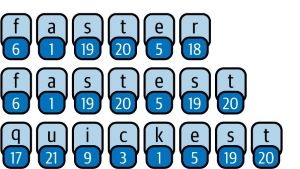


The BertTokenizerFast class handles tokenization and input ID mapping. It inherits from:



*   PreTrainedTokenizerBase (Base Class) → Defines tokenization logic for all transformer models.


*  BertTokenizer (Intermediate Class) → Implements BERT-specific tokenization rules; adds special tokens ( [CLS] -start token, [SEP] - seperator token added after every sequence) ; generates token_type_ids


*   BertTokenizerFast (Optimized Class) → Uses Rust-based fast tokenization for efficiency. This ensures faster and more efficient tokenization while maintaining compatibility with standard BERT

You can look at these classes at https://github.com/huggingface/transformers/blob/main/src/transformers/


\
# **2️. Processing multiple sequences at a time**

The featurizer can also be used with multiple input sequences. In such a case, the BERT tokenizer processes them simultaneously, reducing overhead compared to processing them one by one.

OUTPUT:

Output: The result includes separate arrays for input IDs, attention masks, and token type IDs.
(Here, we will focus only on input ids and attention masks i.e., first and third rows)

# **Extending to SMILES Representation**

Now that we have understood how BERT processes amino acid sequences, we will apply the same concept to SMILES (Simplified Molecular Input Line Entry System), which represents chemical structures as text.

We will now featurize SMILES sequences using BertFeaturizer, ensuring that each token (atoms, bonds, rings) is properly mapped to numerical IDs, just like in amino acid sequences.

Make sure to add spaces between characters in the SMILES strings to ensure proper tokenization and accurate feature extraction.

In [54]:
# Example SMILES dataset
smile_sequences = ["C C ( = O ) O c1 c c c c c1 C ( = O ) O", "C C ( = O ) N c1 c c c ( O ) c c1"]

# Tokenize with padding and truncation
smile_feats = featurizer.featurize(
    smile_sequences,
    padding="max_length",  # Ensures all sequences are of the same length
    truncation=True,       # Truncates if sequence is too long
    max_length=32,         # Set a reasonable max sequence length
    return_tensors="np"    # Convert output to NumPy arrays
)

print(smile_feats[:, [0, 2], :])

[[[[ 2 23 23  1  1 29  1 29  1  1  1  1  1  1 23  1  1 29  1 29  3  0
     0  0  0  0  0  0  0  0  0  0]]

  [[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0
     0  0  0  0  0  0  0  0  0  0]]]


 [[[ 2 23 23  1  1 29  1 17  1  1  1  1  1 29  1  1  1  3  0  0  0  0
     0  0  0  0  0  0  0  0  0  0]]

  [[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0
     0  0  0  0  0  0  0  0  0  0]]]]


## BindingPocketFeaturizer
In computational drug discovery, understanding how a ligand binds to a protein's active site is crucial. DeepChem’s `BindingPocketFeaturizer` helps extract numerical features from binding pockets, which can be used in machine learning models to predict interactions.

`BindingPocketFeaturizer` is a featurizer in DeepChem that extracts structural and chemical information from a protein's binding pockets.

## How it works?
 The BindingPocketFeaturizer in DeepChem is designed to extract numerical features from binding pockets in a protein. These features are useful for Virtual Screening, Binding Pose Prediction in drug discovery.

**Input Requirements**

The featurizer requires:

1. A macromolecule (protein structure) – Typically loaded from a PDB file.

2. A list of binding pockets – These pockets are regions on the protein surface where small molecules (ligands) can bind.

3. Pocket Format – The pockets should be in the form of `dc.utils.CoordinateBox` objects, which are 3D bounding boxes that enclose the binding sites.


In [2]:
! pip install mdtraj

  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.8 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)


In [3]:
import deepchem as dc
import mdtraj as md
from deepchem.dock import ConvexHullPocketFinder

We will start by downloading the `1HSB.pdb` protein structure and use DeepChem’s BindingPocketFeaturizer to extract meaningful features from its binding pockets.

Before featurizing, we need to locate the binding pockets within the protein. This can be done using the `find_pockets()` method, which scan the protein surface and detect potential ligand-binding sites.

**Note:** ConexHullPocketFinder() is the child class of BindingPocketFeaturizer()

In [ ]:
#Example for linking PDB file. Change the path according to your directory and then uncomment the code 
#pdb_id = "1HSB"
#traj = md.load_pdb(f"http://files.rcsb.org/download/{pdb_id}.pdb")
protein_file = f"/content/sample_protien.pdb"
traj.save(protein_file)
pocket_finder = ConvexHullPocketFinder()
pockets = pocket_finder.find_pockets(protein_file)
print(f"Found {len(pockets)} potential binding pockets.")

Found 54 potential binding pockets.


Once the pockets are identified, `BindingPocketFeaturizer` extracts numerical features such as amino acid composition, geometric properties, and chemical characteristics

In [ ]:
binding_featurizer = dc.feat.BindingPocketFeaturizer()
features = binding_featurizer.featurize(protein_file, pockets)
print("Shape of features array:", features.shape)
print(features)

Shape of features array: (54, 24)
[[20. 31. 16. ... 22.  0.  0.]
 [ 5. 42.  7. ...  6.  0.  0.]
 [15. 68.  0. ... 19.  0.  0.]
 ...
 [ 8. 41.  0. ...  9.  0.  0.]
 [28. 31.  8. ... 13.  0.  0.]
 [ 5. 50.  0. ... 12.  0.  0.]]


The `BindingPocketFeaturizer` successfully identified 54 potential binding pockets in the given protein structure. The generated feature array of shape (54, 24) encapsulates essential properties of each pocket, making it suitable for downstream tasks such as binding affinity prediction, virtual screening, and drug discovery.





# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Citing This Tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX. 

In [ ]:
@manual{Intro7, 
 title={Going Deeper on Molecular Featurizations}, 
 organization={DeepChem},
 author={Ramsundar, Bharath}, 
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Going_Deeper_on_Molecular_Featurizations.ipynb}}, 
 year={2021}, 
} 